### MNIST dataset MLP example with synapgrad

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

# Import .././ directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from synapgrad.utils.data import split_dataset, DataLoader, DataLoaderCallback
from synapgrad.utils.train import Trainer, Evaluator

In [3]:
supported_engines = ['synapgrad', 'torch']

In [4]:
seed = 1337
engine_str = 'synapgrad'

In [5]:
epochs = 20
batch_size = 64
lr = 0.01

In [6]:
if engine_str == 'synapgrad':
    import synapgrad as engine
    from synapgrad import nn
    from synapgrad import optim
elif engine_str == 'torch':
    import torch as engine
    from torch import nn
    from torch import optim
engine.manual_seed(seed)
print("Engine:", engine_str)

Engine: synapgrad


Load dataset

In [7]:
(trainX, trainy), (testX, testy) = mnist.load_data()
(trainX, trainy), (valX, valy), _  = split_dataset(trainX, trainy, test_split=0.2)

trainX = trainX / 255.0
valX = valX / 255.0
testX = testX / 255.0

assert 0 <= np.max(trainX) <= 1

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Val: X=%s, y=%s' % (valX.shape, valy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

Train: X=(48000, 28, 28), y=(48000,)
Val: X=(12000, 28, 28), y=(12000,)
Test: X=(10000, 28, 28), y=(10000,)


In [8]:
class Transform(DataLoaderCallback):
    
    def __call__(self, data_loader:'DataLoader', X_batch:np.ndarray, y_batch:np.ndarray):
        if engine_str == 'torch':
            x = engine.tensor(X_batch).type(engine.FloatTensor)
            y = engine.tensor(y_batch).type(engine.LongTensor)
        elif engine_str == 'synapgrad':
            x = engine.tensor(X_batch)
            y = engine.tensor(y_batch, dtype=np.int8)
        return x, y

transform_cb = Transform()

train_loader = DataLoader(trainX, trainy, batch_size, engine=engine, transform=transform_cb)
val_loader = DataLoader(valX, valy, batch_size=256, engine=engine, transform=transform_cb) # big batch size for val samples
test_loader = DataLoader(testX, testy, batch_size=256, engine=engine, transform=transform_cb) # big batch size for val samples

print("Train batches:", len(train_loader), "| Val batches:", len(val_loader), "| Test batches:", len(test_loader))

Train batches: 750 | Val batches: 46 | Test batches: 39


Plot a few training images

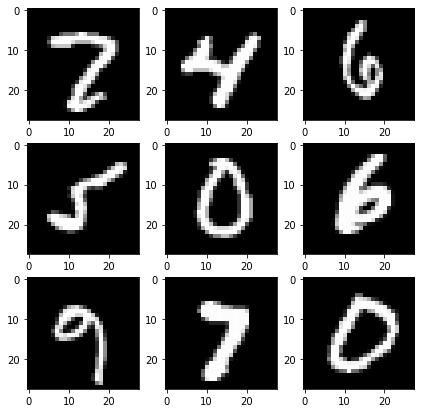

In [9]:
plt.figure(figsize=(7,7))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
plt.show()

In [10]:
class MultiLayerPerceptron(nn.Module):
    
    def __init__(self):
        super().__init__()
    
        self.mlp = nn.Sequential(
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(784, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(200, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1)
        )
        if engine_str == 'synapgrad': self.track_module(self.mlp)
        
    def forward(self, x:engine.Tensor):
        out = self.mlp(x)
        
        return out

model = MultiLayerPerceptron()
print("MLP Model:", model)
print("MLP Trainable Parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

MLP Model: MultiLayerPerceptron(tracked_modules=1, parameters=178710, trainable=178710, non_trainable=0)
MLP Trainable Parameters: 178710


In [11]:
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

trainer = Trainer(model, engine)
evaluator = Evaluator(accuracy=True, mode=Evaluator.MULTI_CLASS)
trainer.compile(loss_fn, optimizer, evaluator)
history = trainer.fit(train_loader, epochs=epochs, validation_loader=val_loader)

Epoch: 1/20
750/750 [================================] - 6s 8ms/step - loss: 0.4072 - accuracy: 0.8801 - val_loss: 0.1803 - val_accuracy: 0.9445
Epoch: 2/20
750/750 [================================] - 6s 8ms/step - loss: 0.2031 - accuracy: 0.9379 - val_loss: 0.1424 - val_accuracy: 0.9553
Epoch: 3/20
750/750 [================================] - 6s 8ms/step - loss: 0.1650 - accuracy: 0.9489 - val_loss: 0.1230 - val_accuracy: 0.9626
Epoch: 4/20
750/750 [================================] - 6s 8ms/step - loss: 0.1352 - accuracy: 0.9568 - val_loss: 0.1152 - val_accuracy: 0.9648
Epoch: 5/20
750/750 [================================] - 6s 8ms/step - loss: 0.1186 - accuracy: 0.9624 - val_loss: 0.1029 - val_accuracy: 0.9680
Epoch: 6/20
750/750 [================================] - 6s 8ms/step - loss: 0.1036 - accuracy: 0.9677 - val_loss: 0.1015 - val_accuracy: 0.9686
Epoch: 7/20
750/750 [================================] - 6s 8ms/step - loss: 0.0923 - accuracy: 0.9714 - val_loss: 0.0969 - val_ac

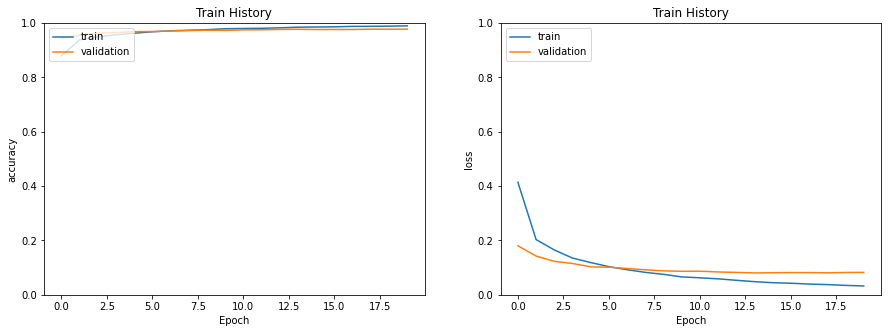

In [12]:
trainer.plot(['accuracy', 'loss'], ylim=[0, 1])

In [13]:
y_pred, y_true = trainer.test(test_loader)
evaluator.report(y_pred, y_true)

[INFO] Testing network...
Accuracy: 0.9777644230769231
[[ 969    0    0    1    1    2    1    1    0    4]
 [   0 1128    1    0    0    0    2    0    2    0]
 [   7    2 1002    3    1    0    2    8    5    0]
 [   1    0    6  985    0    5    0    7    3    1]
 [   1    0    3    1  955    0    1    3    0   16]
 [   3    1    0    7    2  870    3    1    1    2]
 [   3    4    1    1    5    9  931    0    2    0]
 [   2    5   10    2    0    1    0 1000    2    5]
 [   1    0    4    6    2    5    2    3  945    5]
 [   2    3    0    7    5    1    1    9    3  977]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       979
           1       0.99      1.00      0.99      1133
           2       0.98      0.97      0.97      1030
           3       0.97      0.98      0.97      1008
           4       0.98      0.97      0.98       980
           5       0.97      0.98      0.98       890
           6       0.99      0.97  

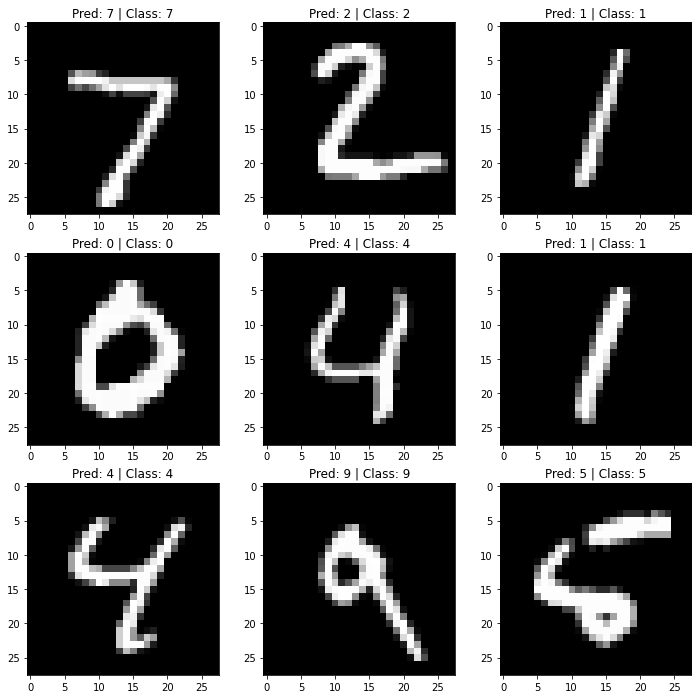

In [14]:
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(testX[i].reshape(28,28), cmap=plt.get_cmap('gray'))
    pred = y_pred[i].argmax(); label = y_true[i]
    plt.title(f"Pred: {pred} | Class: {label}")
plt.show()